# Baseline implementation
This notebook implement the prediction of hypotension using the last mean artrial pressure (MAP) value. It is use as a baseline to compare with other models.

In [8]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc, roc_curve
from scripts.utils import bootstrap_test

In [9]:
HALF_TIME_FILTERING = 10 # secondes
FEATURE_NAME = "dbp"
rng_seed = 42

In [10]:
# import the data frame and add the meta data to the segments
data = pd.read_parquet('data/datasets/base_dataset_no_leading_time/cases/')
static = pd.read_parquet('data/datasets/base_dataset_no_leading_time/meta.parquet')
data = data.merge(static, on='caseid')

data.asa = data.asa.astype(int)
data.preop_htn = data.preop_htn.astype(int)

train = data[data['split'] == "train"]
test = data[data['split'] == "test"]

In [11]:
# for each subgoup of data, create a regressor and evaluate it
n_bootstraps = 200
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)


tpr_list, auc_list, thresh_list  = [], [], []
sensitivity_list, specificity_list, ppv_list, npv_list = [], [], [], []

fpr = np.linspace(0, 1, 100)

# create a regressor
print(f"test set contains {len(test)} sample with a prevalence of {test['label'].mean()*100:.2f}% ")
print(f"train set contains {len(train)} sample with a prevalence of {train['label'].mean()*100:.2f}%")

test = test.dropna(subset=[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'])

x_test = test[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'].values
y_test = test['label'].values
y_pred = 1 - x_test/120
y_label_id = test["label_id"].values


df_results, tpr_list = bootstrap_test(y_test, y_pred, y_label_id, n_bootstraps=n_bootstraps, rng_seed=rng_seed)

result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.exists()
roc_results = result_folder / "baseline_roc.csv"
df_results.to_csv(roc_results, index=False)



test set contains 43864 sample with a prevalence of 9.83% 
train set contains 102434 sample with a prevalence of 5.65%


In [12]:

print(f"AUC = {df_results['auc'][0]:.2f}  [{df_results['auc'][0] - df_results['auc_std'][0]*2:.2f}, {df_results['auc'][0] + df_results['auc_std'][0]*2:.2f}]")
print(f"Sensitivity = {df_results['sensitivity'][0]:.2f}  [{df_results['sensitivity'][0] - df_results['sensitivity_std'][0]*2:.2f}, {df_results['sensitivity'][0] + df_results['sensitivity_std'][0]*2:.2f}] %")
print(f"Specificity = {df_results['specificity'][0]:.2f}  [{df_results['specificity'][0] - df_results['specificity_std'][0]*2:.2f}, {df_results['specificity'][0] + df_results['specificity_std'][0]*2:.2f}] %")
print(f"PPV = {df_results['ppv'][0]:.2f}  [{df_results['ppv'][0] - df_results['ppv_std'][0]*2:.2f}, {df_results['ppv'][0] + df_results['ppv_std'][0]*2:.2f}] %")
print(f"NPV = {df_results['npv'][0]:.2f}  [{df_results['npv'][0] - df_results['npv_std'][0]*2:.2f}, {df_results['npv'][0] + df_results['npv_std'][0]*2:.2f}] %")



AUC = 0.72  [0.72, 0.73]
Sensitivity = 6534.86  [6271.14, 6798.59] %
Specificity = 7025.54  [6788.33, 7262.74] %
PPV = 19.33  [18.39, 20.28] %
NPV = 94.90  [94.61, 95.19] %


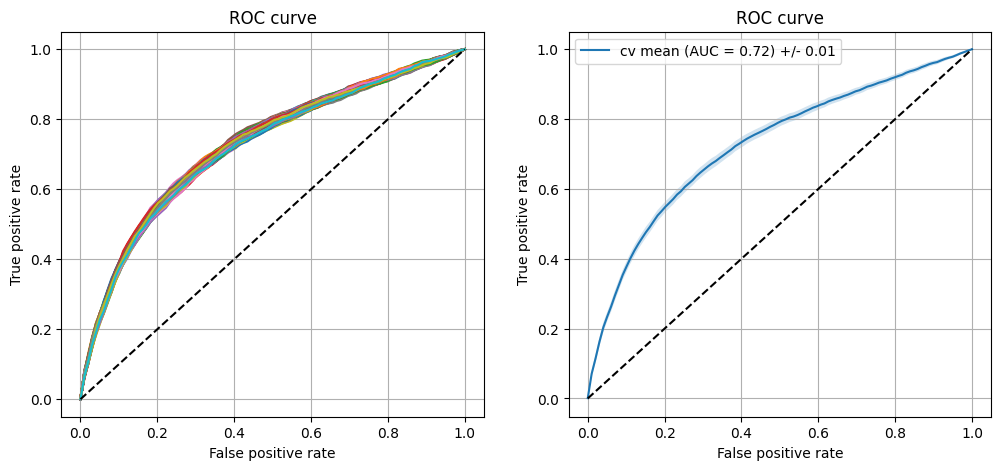

In [13]:


# plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(len(tpr_list)):
    plt.plot(fpr, tpr_list[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.grid()

plt.subplot(1, 2, 2)

plt.fill_between(fpr, df_results['tpr'] - 2*df_results['tpr_std'], df_results['tpr'] + 2*df_results['tpr_std'], alpha=0.2)
plt.plot(fpr, df_results['tpr'], label=f"cv mean (AUC = {df_results['auc'][0]:.2f}) +/- {2*df_results['auc_std'][0]:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.grid()
plt.show()




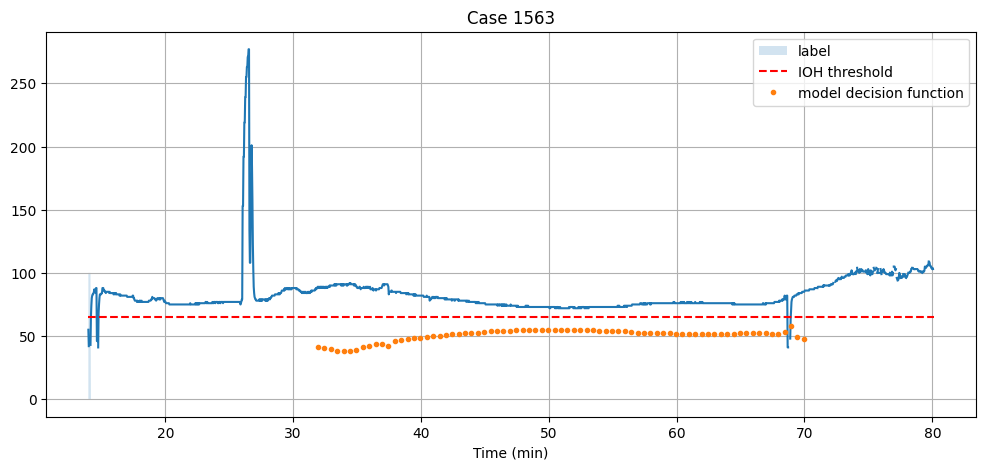

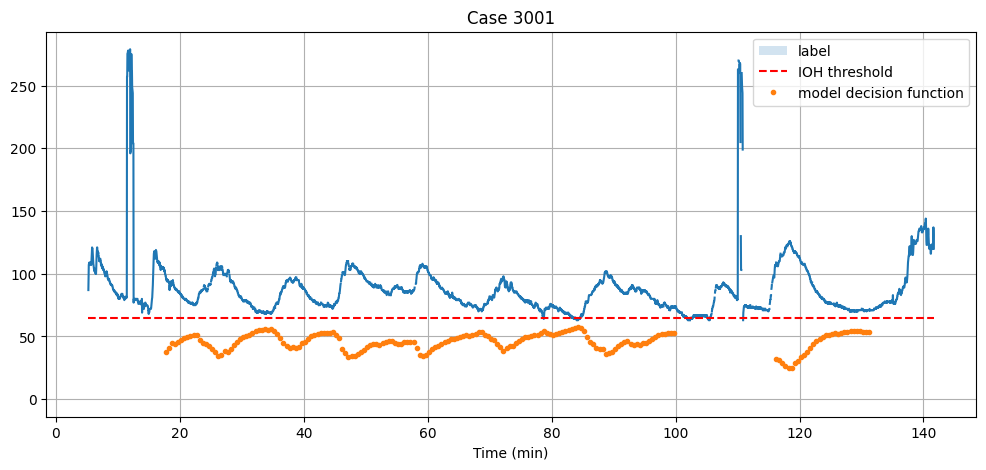

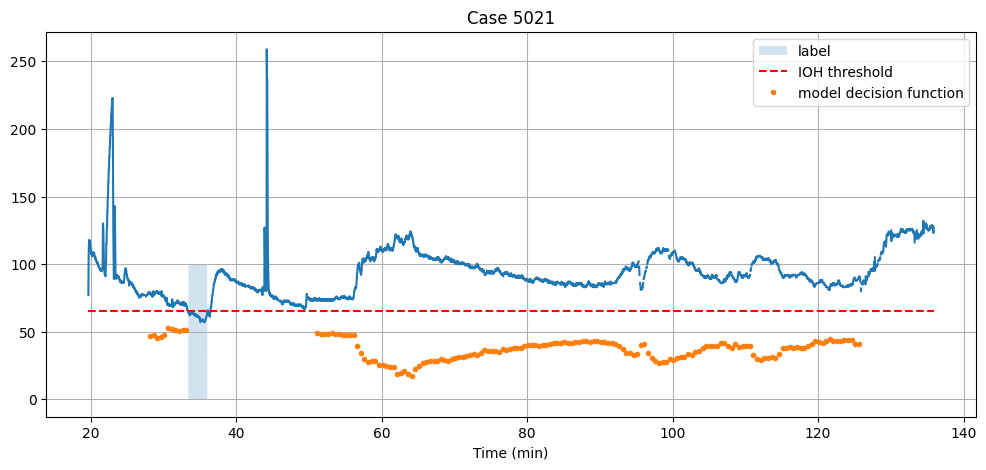

In [14]:
# plot 3 random cases with the corresponding decision function
from scripts.dataLoader import label_caseid

np.random.seed(10)
cases = np.random.choice(test['caseid'].unique(), 3, replace=False)

for case in cases:
    raw_case = pd.read_parquet(f'data/cases/case-{case:04d}.parquet')
    raw_case.rename(columns={'Solar8000/ART_MBP': 'mbp'}, inplace=True)
    raw_case.mbp.mask(raw_case.mbp < 40, inplace=True)
    # removing the nan values at the beginning and the ending
    case_valid_mask = ~raw_case.mbp.isna()
    raw_case = raw_case[(np.cumsum(case_valid_mask) > 0) & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)]

    raw_case.Time = pd.to_timedelta(raw_case.Time, unit="s")
    raw_case.set_index('Time', inplace=True)
    raw_case = raw_case.resample('2s').ffill()
    raw_case= label_caseid(raw_case, 2)

    segment_data = test[test['caseid'] == case]

    segment_data = segment_data.dropna(subset=[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'])
    x_test = segment_data[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'].values.reshape(-1, 1)
    y_test = segment_data['label'].values
    y_pred = 1 - x_test/120

    plt.figure(figsize=(12, 5))
    plt.fill_between(raw_case.index.seconds/60, np.zeros(len(raw_case.index)), raw_case.label*100, label='label', alpha=0.2)
    # FIX: NA values in mbp, missing fillna?
    plt.plot(raw_case.index.seconds/60, raw_case['mbp'])
    plt.hlines(65, raw_case.index.seconds[0]/60, raw_case.index.seconds[-1]/60, color='r', linestyle='--', label='IOH threshold')
    plt.plot(segment_data['time'] / np.timedelta64(1, 's') /60,y_pred*100, '.', label='model decision function')
    # plt.plot(segment_data['time']/60, segment_data[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'], '*', label='label')
    plt.xlabel('Time (min)')
    # plt.xlim([100, 120])
    # plt.xlim([235, 245])
    # plt.ylim([42, 80])
    plt.legend()
    plt.title(f'Case {case}')
    plt.grid()
    plt.show()

